In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import time

from IPython.display import clear_output
from numba import jit, cuda
from numba.typed import List
from plotly.subplots import make_subplots

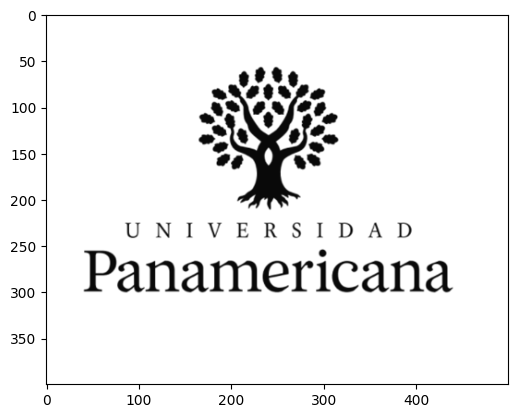

In [2]:
img = plt.imread('../images/UP.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

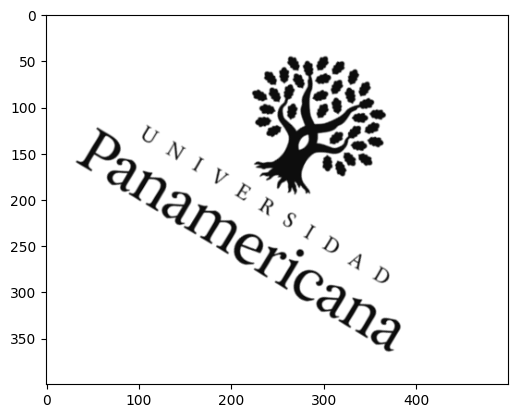

In [3]:
target = plt.imread('../images/UP_ROTATED.png')
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
plt.imshow(target, cmap='gray')

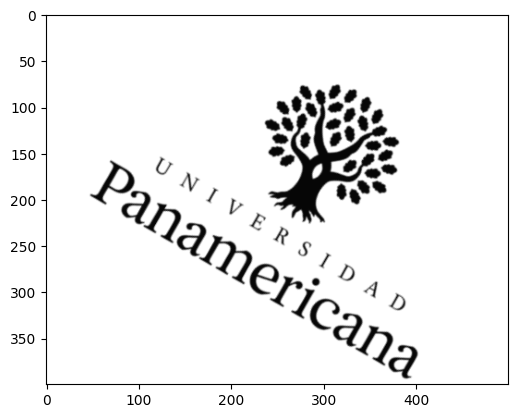

In [4]:
# @jit(target_backend='cuda') 
def to_matrix_function(X, img):
    assert len(X) == 5, "X must be a vector of 5 elements"
    tx, ty, th, sx, sy = X 
    n, m = img.shape[0], img.shape[1]
    th = np.radians(th)
    c, s = np.cos(th), np.sin(th)
    scale = np.array([  [sx,  0, 0],
                        [ 0, sy, 0],
                        [ 0,  0, 1]], dtype=np.float64)
    rotate = np.array([[1,0,n//2],[0,1,m//2],[0,0,1]]) @ np.array([ [c, -s, 0],
                        [s,  c, 0],
                        [0,  0, 1]], dtype=np.float64) @ np.array([[1,0,-n//2],[0,1,-m//2],[0,0,1]])

    translate = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)
    matrix = scale @ rotate @ translate
    return matrix[:2,:]

# Plot the image
aux_img = cv2.warpAffine(img, to_matrix_function([0,-20,30,1,1], img), (img.shape[1], img.shape[0]), borderValue=(1))
plt.imshow(aux_img, cmap='gray')

In [5]:
# Calculate number of white pixels on target
white_treshold = 0.99
white_pixels = np.sum(target > white_treshold)
print(f"Number of white pixels on target: {white_pixels}")
total_pixels = target.shape[0] * target.shape[1]
print('Total pixels on target', total_pixels)

Number of white pixels on target: 179944
Total pixels on target 200000


In [6]:
@jit(target_backend='cuda') 
def fitness(X, target):
    m = to_matrix_function(X, target)
    img_transformed = cv2.warpAffine(img, m, (img.shape[1], img.shape[0]), borderValue=(1))
    different_pixels = np.sum(np.abs(img_transformed - target))
    white_pixels_difference = np.abs(np.sum(img_transformed > white_treshold) - white_pixels)
    return different_pixels * 2 + white_pixels_difference

@jit(target_backend='cuda') 
def population_fitness(population, target):
    fitnesses = np.zeros(len(population))
    for i in range(len(population)):
        fitnesses[i] = fitness(population[i], target)
    return fitnesses

@jit(target_backend='cuda') 
def evolution_strategy(target, sigma_rate, population_size, n_iter, verbose=False):
    population = np.random.normal(0, sigma_rate, (population_size, 5))
    sigma = np.ones((population_size, 5)) * sigma_rate
    fitnesses = population_fitness(population, target)
    best_individual = [population[np.argmin(fitnesses)]]
    best_fitnesses = [np.min(fitnesses)]
    for i in range(n_iter):
        new_population = np.zeros((population_size, 5))
        new_sigma = np.zeros((population_size, 5))
        for j in range(population_size):
            new_sigma[j] = sigma[j] * np.exp(np.random.normal(0, 2.0, 5))
            new_population[j] = population[j] + np.random.normal(0, new_sigma[j])
        new_fitnesses = population_fitness(new_population, target)
        population = np.concatenate((population, new_population))
        sigma = np.concatenate((sigma, new_sigma))
        fitnesses = np.concatenate((fitnesses, new_fitnesses))
        idx = np.argsort(fitnesses)[:population_size]
        population = population[idx]
        sigma = sigma[idx]
        fitnesses = fitnesses[idx]
        best_individual.append(population[0])
        best_fitnesses.append(np.min(fitnesses))
        if verbose:
            clear_output(wait=True)
            print(f"Iteration {i+1}/{n_iter} - Best fitness: {best_fitnesses[-1]}")
    return best_individual, best_fitnesses

Iteration 500/500 - Best fitness: 1709.7100830078125
Time: 181.80561518669128


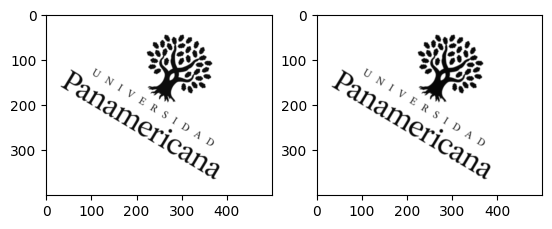

In [7]:
start = time.time()
best_individual, best_fitnesses = evolution_strategy(target, 1.0, 250, 500, verbose=True)
end = time.time()
print(f"Time: {end - start}")

# Plot both target and result
m = to_matrix_function(best_individual[-1], img)
img_transformed = cv2.warpAffine(img, m, (img.shape[1], img.shape[0]), borderValue=(1))
plt.subplot(1,2,1)
plt.imshow(target, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_transformed, cmap='gray')

Text(0.5, 1.0, 'Fitness evolution')

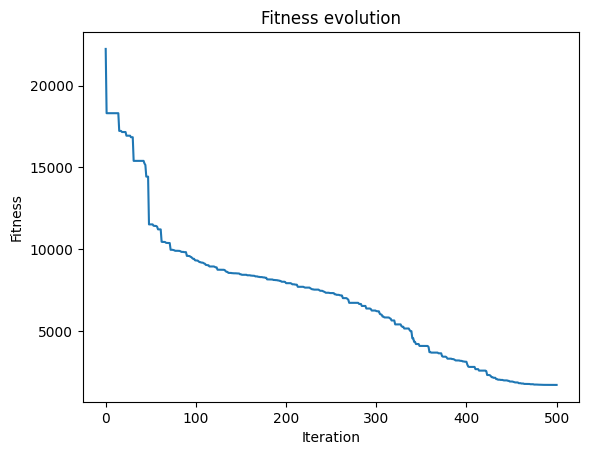

In [8]:
plt.plot(best_fitnesses)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness evolution')